In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
from sklearn.utils import shuffle
import random
#%matplotlib widget
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import os
# plt.style.use('dark_background')

In [2]:
species = ["SO2", "OCS", "HNO3", "HCOOH" , "HCN" , "H2S" , "H2CO", "CH3OH" , "CH3CN" , "CH3CL","CH3CHO" , "C2H5OH"  ]  # Add your class labels in the correct order , "CH3CHO" , "C2H5OH"

global_testing = []
for j in range(0, len(species)):
    x = np.linspace( 0.000396 , 0.021749, 164)
    # Format each value to a string with 6 decimal places
    x = ["{:.6f}".format(value) for value in x]
    spectras = []
    if j<=9:
        file_initial = '/home/sym/One_shotVOC/data/Uniform Training Data Small/{}/{}_HAPI_P'.format(species[j], species[j])
    else:
        file_initial = '/home/sym/One_shotVOC/data/Uniform Training Data Small/{}/{}_JPL_HAPI_P'.format(species[j], species[j])
    for i in x:
        # file_name = '/home/sym/One_shotVOC/data/Uniform Training Data Small/C2H5OH/C2H5OH_JPL_HAPI_P={},T=296,L=21.59,x=1,step=0.016.csv'.format(i)
        file_name = file_initial +'={},T=296,L=21.59,x=1,step=0.016.csv'.format(i)

        df = pd.read_csv(file_name, index_col=None, header=0)
        #spectra = minmax_normalize(df["absorbance"].values)
        spectra = np.reshape(df["absorbance"].values , (1, 251))
        spectras.append(spectra)
    spectras = np.concatenate(spectras, axis =0)
    global_testing.append(spectras)
global_testing = np.concatenate(global_testing)

In [3]:
import numpy as np

# Assuming you have a variable 'data' of size [12000, 251]
# Create target labels using one-hot encoding
num_classes = 12
num_samples = 164

# Initialize an array for target labels
targets = np.zeros((num_samples * num_classes, num_classes))

# Assign 1 to the appropriate column for each class
for i in range(num_classes):
    targets[i * num_samples: (i + 1) * num_samples, i] = 1

# Now 'targets' contains the one-hot encoded labels for your data
# Assuming 'data' is your input data of size [12000, 251]
data_with_targets = np.concatenate([global_testing, targets], axis=1)

In [4]:
from sklearn.model_selection import train_test_split


# Assuming your data is named 'X' (features) and 'y' (labels)
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(global_testing, targets, test_size=0.3, stratify=targets, random_state=42)

# Count the occurrences of each class in the original data
class_counts_original = pd.DataFrame(np.sum(targets, axis=0), columns=['Original Count'])

# Count the occurrences of each class in the training set
class_counts_train = pd.DataFrame(np.sum(y_train, axis=0), columns=['Training Count'])

# Count the occurrences of each class in the testing set
class_counts_test = pd.DataFrame(np.sum(y_test, axis=0), columns=['Testing Count'])

# Concatenate the counts for comparison
class_counts_comparison = pd.concat([class_counts_original, class_counts_train, class_counts_test], axis=1)

# Display the counts
print(class_counts_comparison)


    Original Count  Training Count  Testing Count
0            164.0           115.0           49.0
1            164.0           115.0           49.0
2            164.0           115.0           49.0
3            164.0           115.0           49.0
4            164.0           114.0           50.0
5            164.0           114.0           50.0
6            164.0           115.0           49.0
7            164.0           115.0           49.0
8            164.0           114.0           50.0
9            164.0           115.0           49.0
10           164.0           115.0           49.0
11           164.0           115.0           49.0


In [5]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class C2f3k3_AP1_D48_RD50_D12_Model:

    def __init__(self, input_shape=(251, 1)):
        self.model = Sequential()

        # C1 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', input_shape=input_shape, name='C1'))

        # S2 Subsampling Layer
        self.model.add(layers.AveragePooling1D(pool_size=2, strides=2, padding='valid', name='S2'))

        # C3 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', name='C3'))

        # Flatten the CNN output to feed it with fully connected layers
        self.model.add(layers.Flatten())

        self.model.add(layers.Dense(48, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(12, activation='softmax'))  # Assuming it's a classification task
        self.model.summary()

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, train_data, train_labels, epochs=10, batch_size=32):
        # Assuming 'train_data' is a NumPy array with shape (12, 251, 1)
        # and 'train_labels' is a NumPy array with shape (12,)

        # Convert labels to one-hot encoding if needed
        # For example, using keras.utils.to_categorical
        # train_labels = keras.utils.to_categorical(train_labels, num_classes=12)

        self.model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)
    
    def test_model(self, test_data):
        predictions = self.model.predict(test_data)
        return predictions


# Example usage:
train_data = X_train  # Load and preprocess your training data (shape: (12, 251))
train_labels = y_train# Load your training labels (shape: (12,))
# train_labels = keras.utils.to_categorical(train_labels, num_classes=12)  # Convert labels to one-hot encoding

model_instance = C2f3k3_AP1_D48_RD50_D12_Model()
model_instance.compile_model()
model_instance.train_model(train_data, train_labels, epochs=10, batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, 249, 3)            12        
                                                                 
 S2 (AveragePooling1D)       (None, 124, 3)            0         
                                                                 
 C3 (Conv1D)                 (None, 122, 3)            30        
                                                                 
 flatten (Flatten)           (None, 366)               0         
                                                                 
 dense (Dense)               (None, 48)                17616     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                5

In [6]:
import numpy as np

# Assuming 'spectras' is your test data
predictions = model_instance.test_model(X_test)

# Convert probabilities to one-hot encoding
one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), np.argmax(predictions, axis=1)] = 1
#print(one_hot_predictions)
#np.sum(one_hot_predictions, axis=0)

19/19 [==============================] - 0s 2ms/step


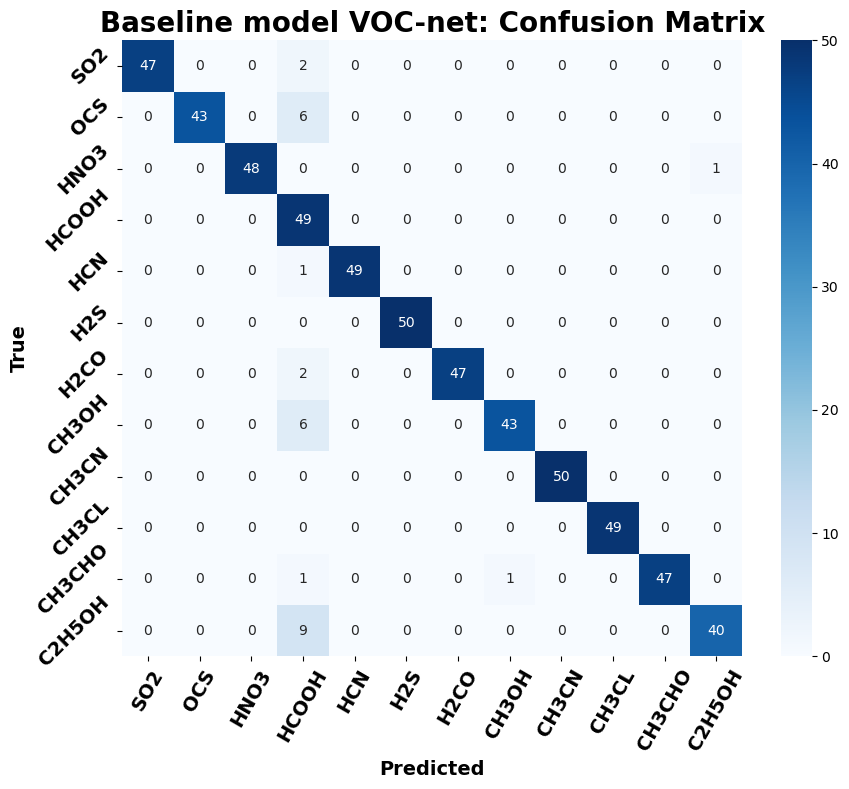

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'targets' and 'predictions' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

dpi = 600

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues', xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])

# Customize x-axis ticks (predicted labels)
plt.xticks(fontweight='bold', fontsize=14, rotation=60)

# Customize y-axis ticks (true labels)
plt.yticks(fontweight='bold', fontsize=14,rotation=45)

plt.xlabel('Predicted', fontweight='bold', fontsize=14)
plt.ylabel('True', fontweight='bold', fontsize=14)
plt.title('Baseline model VOC-net: Confusion Matrix', fontweight='bold', fontsize=20)

# Save the figure with adjusted bounding box
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model.pdf', bbox_inches='tight')

plt.show()


In [ ]:
## test on experiments

In [17]:
import numpy as np
import pandas as pd

species = ["HCOOH", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]
targ = [3, 7, 8, 9, 10, 11]
experiments = []
experiments_targ = []
wn_all=[]
for i in range(0,6):
    for k in range(0,6):
        file_name = '/home/sym/One_shotVOC/data/Experiments/{}/{}.csv'.format(species[i], k+1)
        df = pd.read_csv(file_name, index_col=None, header=0)

#         #columns_to_rename_by_index = [0, 1]  # Replace with the indices of the columns you want to rename
#         #new_column_names = ['wavenumbers', 'abs']  # Replace with the new names

#         # Get the list of column names
#         #column_names = df.columns.tolist()

#         # Rename columns by index
#         #for old_index, new_name in zip(columns_to_rename_by_index, new_column_names):
#          #   if 0 <= old_index < len(column_names):
#                 df.rename(columns={column_names[old_index]: new_name}, inplace=True)
#             else:
#                 print(f"Invalid column index: {old_index}")
#         new_size = 20000
#         indices = np.linspace(0, df["abs"].values.size - 1, new_size)
#         absorbance = np.interp(indices, np.arange(df["abs"].values.size), df["abs"].values)
#         wn = np.interp(indices, np.arange(df["wavenumbers"].values.size), df["wavenumbers"].values)

        experiments.append(np.reshape(df.values, (1, 251)))
        #wn_all.append(np.reshape(wn , (1, new_size)))
    targ_temp = np.zeros((6, 12))
    targ_temp[:, targ[i]] = 1
    experiments_targ.append(targ_temp)
experiments=np.reshape(experiments , (36, 251))
experiments_targ=np.reshape(experiments_targ , (36, 12))

In [9]:
#experiments_targ
experiments_targ[12]=[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]

2/2 [==============================] - 0s 2ms/step


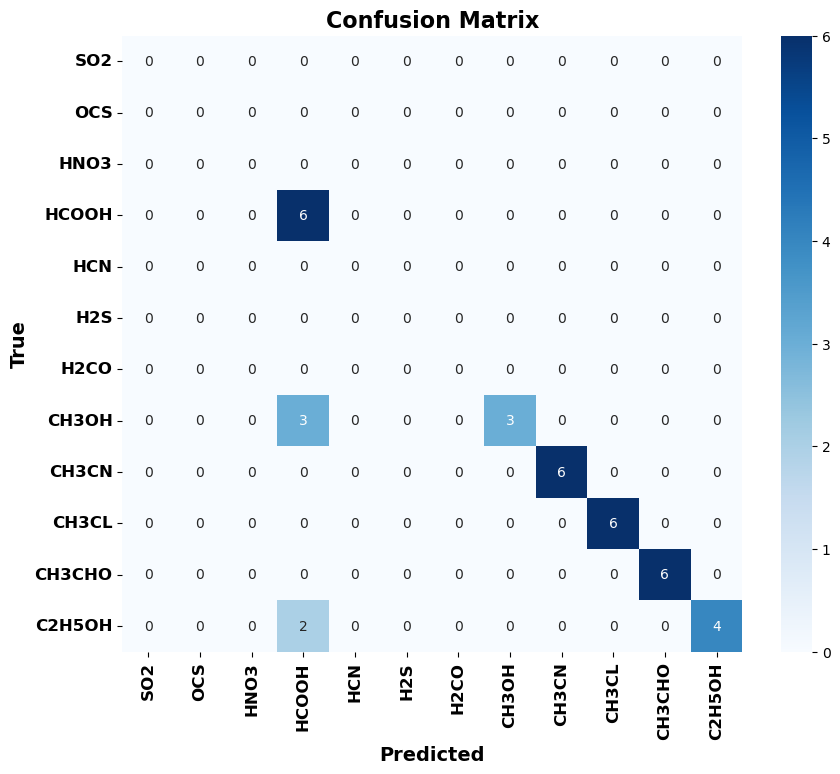

In [12]:
from sklearn.metrics import confusion_matrix
# Assuming 'spectras' is your test data
species = ["SO2", "OCS", "HNO3", "HCOOH" , "HCN" , "H2S" , "H2CO", "CH3OH" , "CH3CN" , "CH3CL","CH3CHO" , "C2H5OH"  ]  # Add your class labels in the correct order , "CH3CHO" , "C2H5OH"
predictions_experiemnt = model_instance.test_model(experiments)

# Convert probabilities to one-hot encoding
one_hot_predictionsexp = np.zeros_like(predictions_experiemnt)
one_hot_predictionsexp[np.arange(len(predictions_experiemnt)), np.argmax(predictions_experiemnt, axis=1)] = 1
# Assuming 'targets' and 'predictions' are your binary data arrays
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp= confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Plot the confusion matrix heatmap with counts
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues', xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])

# # Add count annotations to the top of the heatmap
# for i in range(12):
#     for j in range(12):
#         text_count = f"{conf_matrix[i, j]}"
#         plt.text(j + 0.5, i + 0.8, text_count, ha='center', va='center', color='black', fontweight='bold')
# Customize x-axis ticks (predicted labels)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)

plt.xlabel('Predicted', fontweight='bold', fontsize=14)
plt.ylabel('True', fontweight='bold', fontsize=14)
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
# plt.savefig('vocnet_experiments.png', transparent=True)
plt.show()


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'species' is your class labels
species = ["SO2", "OCS", "HNO3", "HCOOH", "HCN", "H2S", "H2CO", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]

# Assuming 'targets_HAPI' and 'predictions_HAPI' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Set up the first subplot for the HAPI model
plt.figure(figsize=(26, 9))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues',
            xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])
plt.xticks(fontweight='bold', fontsize=16,rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=16)
plt.ylabel('True', fontweight='bold', fontsize=16)
plt.title('(a) Tested on simulated data', fontweight='bold', fontsize=20)

# Assuming 'targets_exp' and 'predictions_exp' are your binary data arrays
# Assuming 'species' is your class labels for experimental data
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp = confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Set up the second subplot for the experimental data
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])
plt.xticks(fontweight='bold', fontsize=16,rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=16)
plt.ylabel('True', fontweight='bold', fontsize=16)
plt.title('(b) Tested on experimental data', fontweight='bold', fontsize=20)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=2.5)
plt.gcf().patch.set_facecolor('none')
dpi = 600
plt.gcf().set_dpi(dpi)
# Adjust layout to prevent overlap
# plt.style.use('white_background')
plt.tight_layout()
# Save the plot with no background
# plt.style.use('dark_background')

# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model__dark_final.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model_dark_final.png', bbox_inches='tight', transparent=True)

# Save the plot with a dark background
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model_final_dark.png', bbox_inches='tight', transparent=True)

# Reset the background to no_background
# plt.style.use('dark_background')

# Show the combined plot
plt.show()


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'species' is your class labels
species = ["SO2", "OCS", "HNO3", "HCOOH", "HCN", "H2S", "H2CO", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]

# Assuming 'targets_HAPI' and 'predictions_HAPI' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Function to set different font sizes and colors
def annotate_heatmap(ax, data, fmt='d', fontsize_small=10, fontsize_large=20):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, format(data[i, j], fmt),
                           ha='center', va='center',
                           fontsize=fontsize_large if data[i, j] != 0 else fontsize_small,
                           color='white' if data[i, j] > np.max(data)/2 else 'black')

# Set up the first subplot for the HAPI model
plt.figure(figsize=(26, 9))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(a) Tested on simulated data', fontweight='bold', fontsize=26)

cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
# Adjust annotation sizes and colors
annotate_heatmap(ax1, conf_matrix_HAPI)

# Assuming 'targets_exp' and 'predictions_exp' are your binary data arrays
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp = confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Set up the second subplot for the experimental data
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(b) Tested on experimental data', fontweight='bold', fontsize=26)

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Adjust annotation sizes and colors
annotate_heatmap(ax2, conf_matrix_exp)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=1.5)
plt.gcf().patch.set_facecolor('none')
dpi = 600
plt.gcf().set_dpi(dpi)
plt.tight_layout()
plt.savefig('/home/sym/One_shotVOC/final/baseline_final.pdf', bbox_inches='tight', dpi= 600, transparent=True)
plt.savefig('/home/sym/One_shotVOC/final/baseline_final.png', bbox_inches='tight', dpi=600, transparent=True)

plt.show()

# Save the plot with a dark background
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model_final_dark.png', bbox_inches='tight', transparent=True)


## saved results 

In [33]:
np.savetxt('one_hot_predictions.csv', one_hot_predictions, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

## call saved results and plot conf matrix 

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved CSV files
one_hot_predictions = np.loadtxt('one_hot_predictions.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

# Assuming 'species' is your class labels
species = ["SO2", "OCS", "HNO3", "HCOOH", "HCN", "H2S", "H2CO", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]

# Assuming 'targets_HAPI' and 'predictions_HAPI' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Function to set different font sizes and colors
def annotate_heatmap(ax, data, fmt='d', fontsize_small=10, fontsize_large=20):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, format(data[i, j], fmt),
                           ha='center', va='center',
                           fontsize=fontsize_large if data[i, j] != 0 else fontsize_small,
                           color='white' if data[i, j] > np.max(data)/2 else 'black')

# Set up the first subplot for the HAPI model
plt.figure(figsize=(26, 9))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(a) Tested on simulated data', fontweight='bold', fontsize=26)

cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
# Adjust annotation sizes and colors
annotate_heatmap(ax1, conf_matrix_HAPI)

# Assuming 'targets_exp' and 'predictions_exp' are your binary data arrays
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp = confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Set up the second subplot for the experimental data
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(b) Tested on experimental data', fontweight='bold', fontsize=26)

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Adjust annotation sizes and colors
annotate_heatmap(ax2, conf_matrix_exp)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=1.5)
plt.gcf().patch.set_facecolor('none')
dpi = 600
plt.gcf().set_dpi(dpi)
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'targets_HAPI', 'predictions_HAPI', 'targets_exp', and 'predictions_exp' are your data arrays
# Assuming 'species' is your class labels

# Calculate metrics for HAPI model
accuracy_HAPI = accuracy_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))
precision_HAPI = precision_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')
recall_HAPI = recall_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')
f1_HAPI = f1_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')

# Calculate metrics for experimental data
accuracy_exp = accuracy_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1))
precision_exp = precision_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')
recall_exp = recall_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')
f1_exp = f1_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')

# Print the results
print("Metrics for HAPI model:")
print("Accuracy:", accuracy_HAPI)
print("Precision:", precision_HAPI)
print("Recall:", recall_HAPI)
print("F1 Score:", f1_HAPI)
print("\nMetrics for Experimental data:")
print("Accuracy:", accuracy_exp)
print("Precision:", precision_exp)
print("Recall:", recall_exp)
print("F1 Score:", f1_exp)


Metrics for HAPI model:
Accuracy: 0.9644670050761421
Precision: 0.9732290841739477
Recall: 0.9644670050761421
F1 Score: 0.9663275437549264

Metrics for Experimental data:
Accuracy: 0.8888888888888888
Precision: 0.9120370370370369
Recall: 0.8888888888888888
F1 Score: 0.8902777777777777


## VOC train on one pressure 

In [7]:
file_names = ['/home/sym/One_shotVOC/data/Uniform Training Data Small/SO2/SO2_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
'/home/sym/One_shotVOC/data/Uniform Training Data Small/OCS/OCS_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
'/home/sym/One_shotVOC/data/Uniform Training Data Small/HNO3/HNO3_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/HCOOH/HCOOH_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/HCN/HCN_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/H2S/H2S_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
'/home/sym/One_shotVOC/data/Uniform Training Data Small/H2CO/H2CO_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
'/home/sym/One_shotVOC/data/Uniform Training Data Small/CH3OH/CH3OH_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/CH3CN/CH3CN_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/CH3CL/CH3CL_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
'/home/sym/One_shotVOC/data/Uniform Training Data Small/CH3CHO/CH3CHO_JPL_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv',
 '/home/sym/One_shotVOC/data/Uniform Training Data Small/C2H5OH/C2H5OH_JPL_HAPI_P=0.010614,T=296,L=21.59,x=1,step=0.016.csv']

In [8]:
one_pressure_data = []
for i in range (0, len(file_names)):
    file_name =file_names[i]
    df_ =pd.read_csv(file_name, index_col=None, header=0)
    refs = np.reshape (df_["absorbance"].values , (1,251))
    one_pressure_data.append(refs)

one_pressure_data = np.concatenate(one_pressure_data)

# Assuming you have a variable 'data' of size [12000, 251]
# Create target labels using one-hot encoding
num_classes = 12
num_samples = 1

# Initialize an array for target labels
one_pressure_targets = np.zeros((num_samples * num_classes, num_classes))

# Assign 1 to the appropriate column for each class
for i in range(num_classes):
    one_pressure_targets[i * num_samples: (i + 1) * num_samples, i] = 1

# Now 'targets' contains the one-hot encoded labels for your data
# Assuming 'data' is your input data of size [12000, 251]
data_with_targets = np.concatenate([one_pressure_data, one_pressure_targets ], axis=1)

In [9]:

import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class C2f3k3_AP1_D48_RD50_D12_Model:

    def __init__(self, input_shape=(251, 1)):
        self.model = Sequential()

        # C1 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', input_shape=input_shape, name='C1'))

        # S2 Subsampling Layer
        self.model.add(layers.AveragePooling1D(pool_size=2, strides=2, padding='valid', name='S2'))

        # C3 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', name='C3'))

        # Flatten the CNN output to feed it with fully connected layers
        self.model.add(layers.Flatten())

        self.model.add(layers.Dense(48, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(12, activation='softmax'))  # Assuming it's a classification task
        self.model.summary()

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, train_data, train_labels, epochs=10, batch_size=32):
        # Assuming 'train_data' is a NumPy array with shape (12, 251, 1)
        # and 'train_labels' is a NumPy array with shape (12,)

        # Convert labels to one-hot encoding if needed
        # For example, using keras.utils.to_categorical
        # train_labels = keras.utils.to_categorical(train_labels, num_classes=12)

        self.model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)
    
    def test_model(self, test_data):
        predictions = self.model.predict(test_data)
        return predictions
# Example usage:
train_data = one_pressure_data # Load and preprocess your training data (shape: (12, 251))
train_labels = one_pressure_targets # Load your training labels (shape: (12,))
# train_labels = keras.utils.to_categorical(train_labels, num_classes=12)  # Convert labels to one-hot encoding

model_instance = C2f3k3_AP1_D48_RD50_D12_Model()
model_instance.compile_model()
model_instance.train_model(train_data, train_labels, epochs=10, batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, 249, 3)            12        
                                                                 
 S2 (AveragePooling1D)       (None, 124, 3)            0         
                                                                 
 C3 (Conv1D)                 (None, 122, 3)            30        
                                                                 
 flatten (Flatten)           (None, 366)               0         
                                                                 
 dense (Dense)               (None, 48)                17616     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                5

In [14]:
import numpy as np

# Assuming 'spectras' is your test data
predictions = model_instance.test_model(X_test)
# Convert probabilities to one-hot encoding
one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), np.argmax(predictions, axis=1)] = 1
#print(one_hot_predictions)
#np.sum(one_hot_predictions, axis=0)

19/19 [==============================] - 0s 2ms/step


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'targets' and 'predictions' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Plot the confusion matrix heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues', xticklabels=['{}'.format(i) for i in species],
#             yticklabels=['{}'.format(i) for i in species])

# # Customize x-axis ticks (predicted labels)
# plt.xticks(fontweight='bold', fontsize=12)

# # Customize y-axis ticks (true labels)
# plt.yticks(fontweight='bold', fontsize=12)

# plt.xlabel('Predicted', fontweight='bold', fontsize=14)
# plt.ylabel('True', fontweight='bold', fontsize=14)
# plt.title('Confusion Matrix', fontweight='bold', fontsize=16)

# plt.savefig('voc_1_shot_stratified.png', transparent=True)
# plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
# Assuming 'spectras' is your test data
species = ["SO2", "OCS", "HNO3", "HCOOH" , "HCN" , "H2S" , "H2CO", "CH3OH" , "CH3CN" , "CH3CL","CH3CHO" , "C2H5OH"  ]  # Add your class labels in the correct order , "CH3CHO" , "C2H5OH"
predictions_experiemnt = model_instance.test_model(experiments)

# Convert probabilities to one-hot encoding
one_hot_predictionsexp = np.zeros_like(predictions_experiemnt)
one_hot_predictionsexp[np.arange(len(predictions_experiemnt)), np.argmax(predictions_experiemnt, axis=1)] = 1
# Assuming 'targets' and 'predictions' are your binary data arrays
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp= confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# # # Add count annotations to the top of the heatmap
# # for i in range(12):
# #     for j in range(12):
# #         text_count = f"{conf_matrix[i, j]}"
# #         plt.text(j + 0.5, i + 0.8, text_count, ha='center', va='center', color='black', fontweight='bold')
# # Customize x-axis ticks (predicted labels)
# plt.xticks(fontweight='bold', fontsize=12)
# plt.yticks(fontweight='bold', fontsize=12)

# plt.xlabel('Predicted', fontweight='bold', fontsize=14)
# plt.ylabel('True', fontweight='bold', fontsize=14)
# plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
# plt.savefig('vocnet_one_shot_experiments.png', transparent=True)
# plt.show()


2/2 [==============================] - 0s 2ms/step


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'species' is your class labels
species = ["SO2", "OCS", "HNO3", "HCOOH", "HCN", "H2S", "H2CO", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]

# Assuming 'targets_HAPI' and 'predictions_HAPI' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Set up the first subplot for the HAPI model
plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues',
            xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Predicted', fontweight='bold', fontsize=14)
plt.ylabel('True', fontweight='bold', fontsize=14)
plt.title('(a) Tested on simulated data', fontweight='bold', fontsize=16)

# Assuming 'targets_exp' and 'predictions_exp' are your binary data arrays
# Assuming 'species' is your class labels for experimental data
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp = confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Set up the second subplot for the experimental data
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['{}'.format(i) for i in species],
            yticklabels=['{}'.format(i) for i in species])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Predicted', fontweight='bold', fontsize=14)
plt.ylabel('True', fontweight='bold', fontsize=14)
plt.title('(b) Tested on experimental data', fontweight='bold', fontsize=16)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=2.5)
plt.gcf().patch.set_facecolor('none')
dpi = 600
plt.gcf().set_dpi(dpi)
# Adjust layout to prevent overlap
# plt.style.use('white_background')
plt.tight_layout()
# Save the plot with no background
# plt.style.use('dark_background')

# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/voc-lite_model__dark_final.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/voc-lite_model_dark_final.png', bbox_inches='tight', transparent=True)

# Save the plot with a dark background
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model_final_dark.png', bbox_inches='tight', transparent=True)

# Reset the background to no_background
# plt.style.use('default')
# plt.style.use('dark_background')

# Show the combined plot
plt.show()


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'species' is your class labels
species = ["SO2", "OCS", "HNO3", "HCOOH", "HCN", "H2S", "H2CO", "CH3OH", "CH3CN", "CH3CL", "CH3CHO", "C2H5OH"]

# Assuming 'targets_HAPI' and 'predictions_HAPI' are your binary data arrays
targets_HAPI = y_test   # Replace with your actual target data
predictions_HAPI = one_hot_predictions  # Replace with your actual predicted data

# Get the confusion matrix
conf_matrix_HAPI = confusion_matrix(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))

# Function to set different font sizes and colors
def annotate_heatmap(ax, data, fmt='d', fontsize_small=10, fontsize_large=20):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, format(data[i, j], fmt),
                           ha='center', va='center',
                           fontsize=fontsize_large if data[i, j] != 0 else fontsize_small,
                           color='white' if data[i, j] > np.max(data)/2 else 'black')

# Set up the first subplot for the HAPI model
plt.figure(figsize=(26, 9))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(conf_matrix_HAPI, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(a) Tested on simulated data', fontweight='bold', fontsize=26)

cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
# Adjust annotation sizes and colors
annotate_heatmap(ax1, conf_matrix_HAPI)

# Assuming 'targets_exp' and 'predictions_exp' are your binary data arrays
targets_exp = experiments_targ   # Replace with your actual target data
predictions_exp = one_hot_predictionsexp  # Replace with your actual predicted data

# Get the confusion matrix for 12 classes
conf_matrix_exp = confusion_matrix(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), labels=range(12))

# Set up the second subplot for the experimental data
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(conf_matrix_exp, annot=True, fmt='d', cmap='Blues',
                  xticklabels=species, yticklabels=species,
                  cbar=True, annot_kws={"size": 16})
plt.xticks(fontweight='bold', fontsize=16, rotation=60)
plt.yticks(fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=20)
plt.ylabel('True', fontweight='bold', fontsize=20)
plt.title('(b) Tested on experimental data', fontweight='bold', fontsize=26)

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Adjust annotation sizes and colors
annotate_heatmap(ax2, conf_matrix_exp)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=1.5)
plt.gcf().patch.set_facecolor('none')
dpi = 600
plt.gcf().set_dpi(dpi)
plt.tight_layout()
plt.savefig('/home/sym/One_shotVOC/final/lite_final.pdf', bbox_inches='tight', dpi= 600, transparent=True)
plt.savefig('/home/sym/One_shotVOC/final/lite_final.png', bbox_inches='tight', dpi=600, transparent=True)

plt.show()

# Save the plot with a dark background
# plt.savefig('/home/sym/One_shotVOC/binary_VOC_figures/baseline_model_final_dark.png', bbox_inches='tight', transparent=True)


In [23]:
np.savetxt('one_hot_predictions_lite.csv', one_hot_predictions, delimiter=',')
np.savetxt('y_test_lite.csv', y_test, delimiter=',')

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'targets_HAPI', 'predictions_HAPI', 'targets_exp', and 'predictions_exp' are your data arrays
# Assuming 'species' is your class labels

# Calculate metrics for HAPI model
accuracy_HAPI = accuracy_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1))
precision_HAPI = precision_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')
recall_HAPI = recall_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')
f1_HAPI = f1_score(targets_HAPI.argmax(axis=1), predictions_HAPI.argmax(axis=1), average='weighted')

# Calculate metrics for experimental data
accuracy_exp = accuracy_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1))
precision_exp = precision_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')
recall_exp = recall_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')
f1_exp = f1_score(targets_exp.argmax(axis=1), predictions_exp.argmax(axis=1), average='weighted')

# Print the results
print("Metrics for HAPI model:")
print("Accuracy:", accuracy_HAPI)
print("Precision:", precision_HAPI)
print("Recall:", recall_HAPI)
print("F1 Score:", f1_HAPI)
print("\nMetrics for Experimental data:")
print("Accuracy:", accuracy_exp)
print("Precision:", precision_exp)
print("Recall:", recall_exp)
print("F1 Score:", f1_exp)


Metrics for HAPI model:
Accuracy: 0.46362098138747887
Precision: 0.31479453528731144
Recall: 0.46362098138747887
F1 Score: 0.35326418678601457

Metrics for Experimental data:
Accuracy: 0.5
Precision: 0.38333333333333336
Recall: 0.5
F1 Score: 0.40888047138047134


/sw/rl9g/machine_learning/2023.01/rl9_cudnn8_cuda11.8_py3.9_env/machine_learning-module/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/rl9g/machine_learning/2023.01/rl9_cudnn8_cuda11.8_py3.9_env/machine_learning-module/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/rl9g/machine_learning/2023.01/rl9_cudnn8_cuda11.8_py3.9_env/machine_learning-module/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with

In [91]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class C2f3k3_AP1_D48_RD50_D12_Model:

    def __init__(self, input_shape=(10000, 1)):
        self.model = Sequential()

        # C1 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', input_shape=input_shape, name='C1'))

        # S2 Subsampling Layer
        self.model.add(layers.AveragePooling1D(pool_size=2, strides=2, padding='valid', name='S2'))

        # C3 Convolutional Layer
        self.model.add(layers.Conv1D(filters=3, kernel_size=3, activation='relu', name='C3'))

        # Flatten the CNN output to feed it with fully connected layers
        self.model.add(layers.Flatten())

        self.model.add(layers.Dense(48, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(12, activation='softmax'))  # Assuming it's a classification task
        self.model.summary()

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, train_data, train_labels, epochs=10, batch_size=32):
        # Assuming 'train_data' is a NumPy array with shape (num_samples, 10000, 1)
        # and 'train_labels' is a NumPy array with shape (num_samples,)

        # Convert labels to one-hot encoding if needed
        # For example, using keras.utils.to_categorical
        # train_labels = keras.utils.to_categorical(train_labels, num_classes=12)

        self.model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)
    
    def test_model(self, test_data):
        predictions = self.model.predict(test_data)
        return predictions